In [372]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

np.random.seed(42)

### Code for Exercise 6.9


In [373]:
class WindyGridworld:
    def __init__(self, n_actions=4):
        self.height = 7
        self.width = 10

        self.start = (3, 0)
        self.goal = (3, 7)

        # Wind strength
        self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

        self.actions = [(-1, 0), (1, 0), (0, 1), (0, -1)]

        if n_actions == 8 or n_actions == 9:
            self.actions += [
                (-1, 1),  # up-right
                (-1, -1),  # up-left
                (1, 1),  # down-right
                (1, -1),  # down-left
            ]

        if n_actions == 9:
            self.actions += [
                (0, 0),  # no-op
            ]

        self.n_actions = n_actions

    def step(self, state, action_idx):
        row, col = state

        action = self.actions[action_idx]

        new_row = row + action[0]
        new_col = col + action[1]

        wind_strength = self.wind[col]
        new_row -= wind_strength

        # Bound within grid
        new_row = max(0, min(self.height - 1, new_row))
        new_col = max(0, min(self.width - 1, new_col))

        next_state = (new_row, new_col)
        reward = -1

        return next_state, reward

    def is_terminal(self, state):
        return state == self.goal

    def reset(self):
        return self.start

In [374]:
def epsilon_greedy_policy(Q, state, n_actions, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(n_actions)
    else:
        q_values = [Q[(state, a)] for a in range(n_actions)]

        max_q = max(q_values)

        best_actions = [a for a in range(n_actions) if Q[(state, a)] == max_q]

        return np.random.choice(best_actions)


def sarsa(env, n_episodes=500, alpha=0.5, epsilon=0.1, gamma=1.0):
    Q = defaultdict(float)

    episode_lengths = []

    for episode in range(n_episodes):
        state = env.reset()

        action = epsilon_greedy_policy(Q, state, env.n_actions, epsilon)

        steps = 0

        while not env.is_terminal(state):
            # Take action
            next_state, reward = env.step(state, action)

            # Choose next action
            next_action = epsilon_greedy_policy(Q, next_state, env.n_actions, epsilon)

            # SARSA update
            if env.is_terminal(next_state):
                Q[(state, action)] += alpha * (reward - Q[(state, action)])
            else:
                target = reward + gamma * Q[(next_state, next_action)]

                Q[(state, action)] += alpha * (target - Q[(state, action)])

            state = next_state
            action = next_action
            steps += 1

        episode_lengths.append(steps)

    return Q, episode_lengths

In [375]:
def get_greedy_path(env, Q):
    path = [env.start]

    state = env.start

    max_steps = 100

    for _ in range(max_steps):
        if env.is_terminal(state):
            break

        q_values = [Q[(state, a)] for a in range(env.n_actions)]

        action = np.argmax(q_values)

        # Take action
        next_state, _ = env.step(state, action)

        path.append(next_state)

        state = next_state

    return path

In [376]:
def visualize_grid_and_path(env, Q):
    plt.figure(figsize=(10, 7))

    # Draw grid
    for i in range(env.height + 1):
        plt.axhline(i, color="gray", linewidth=0.5)

    for j in range(env.width + 1):
        plt.axvline(j, color="gray", linewidth=0.5)

    start_row, start_col = env.start
    goal_row, goal_col = env.goal

    plt.scatter(
        start_col + 0.5,
        env.height - start_row - 0.5,
        s=500,
        c="green",
        marker="s",
        label="Start",
        zorder=3,
    )
    plt.scatter(
        goal_col + 0.5,
        env.height - goal_row - 0.5,
        s=500,
        c="red",
        marker="s",
        label="Goal",
        zorder=3,
    )

    path = get_greedy_path(env, Q)

    print("Length of Optimal Path:", len(path) - 1)

    path_x = [col + 0.5 for row, col in path]
    path_y = [env.height - row - 0.5 for row, col in path]

    plt.plot(path_x, path_y, "b-", linewidth=2, alpha=0.6, label="Optimal path")

    plt.xlim(0, env.width)
    plt.ylim(0, env.height)
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.title(f"Windy Gridworld - {env.n_actions} action")
    plt.legend()
    plt.gca().invert_yaxis()
    plt.gca().set_aspect("equal")
    plt.tight_layout()
    plt.show()

In [395]:
results = {}

Length of Optimal Path: 16


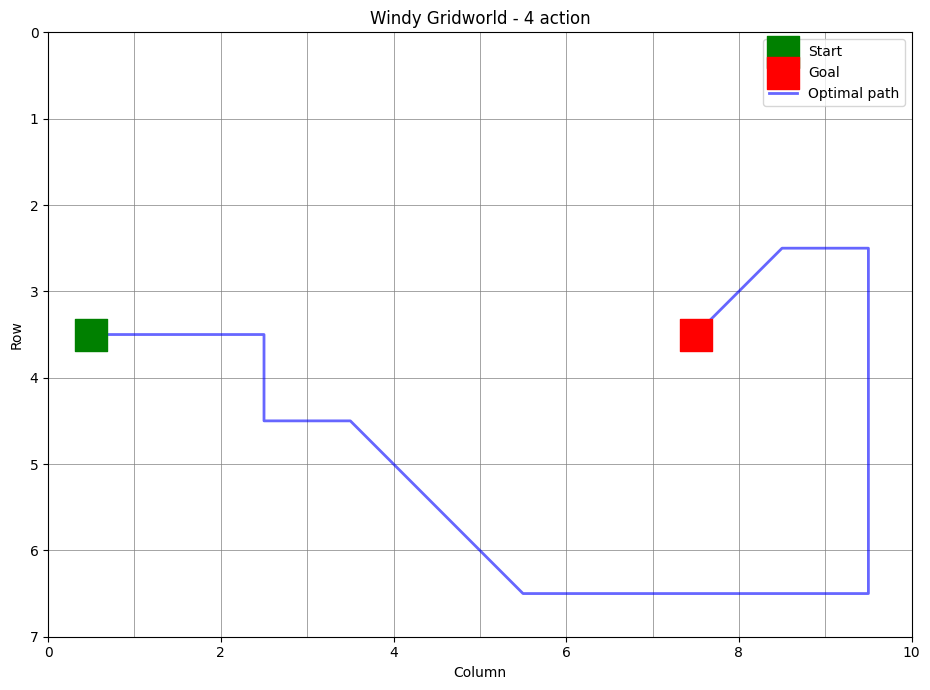

In [396]:
env = WindyGridworld(4)

Q, episode_lengths = sarsa(env, n_episodes=500, alpha=0.5, epsilon=0.1)

results[4] = (Q, episode_lengths)

visualize_grid_and_path(env, Q)

Length of Optimal Path: 7


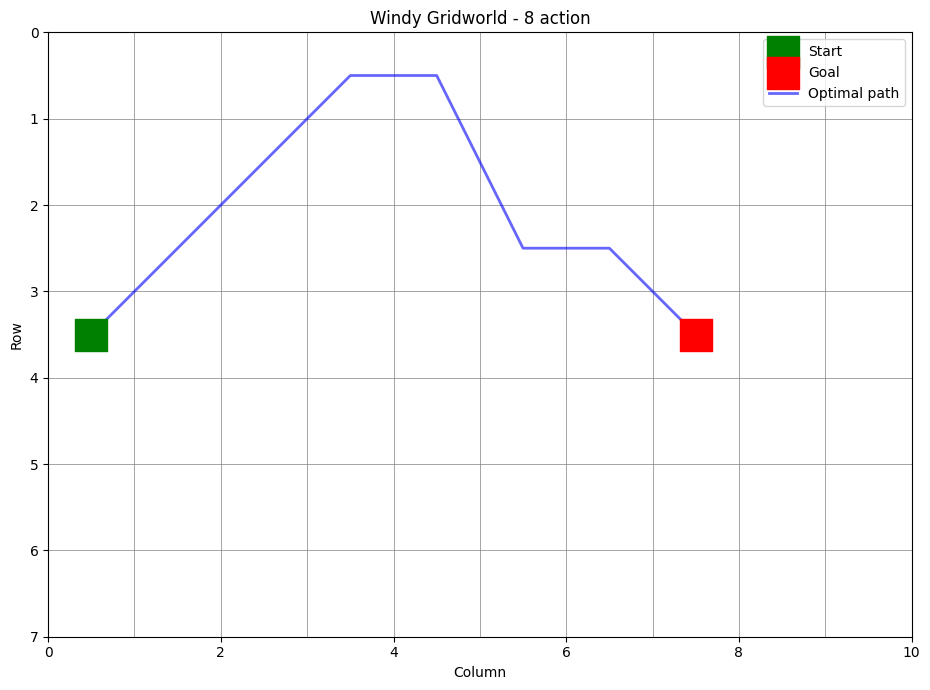

In [397]:
env = WindyGridworld(8)

Q, episode_lengths = sarsa(env, n_episodes=500, alpha=0.5, epsilon=0.1)

results[8] = (Q, episode_lengths)

visualize_grid_and_path(env, Q)

Length of Optimal Path: 7


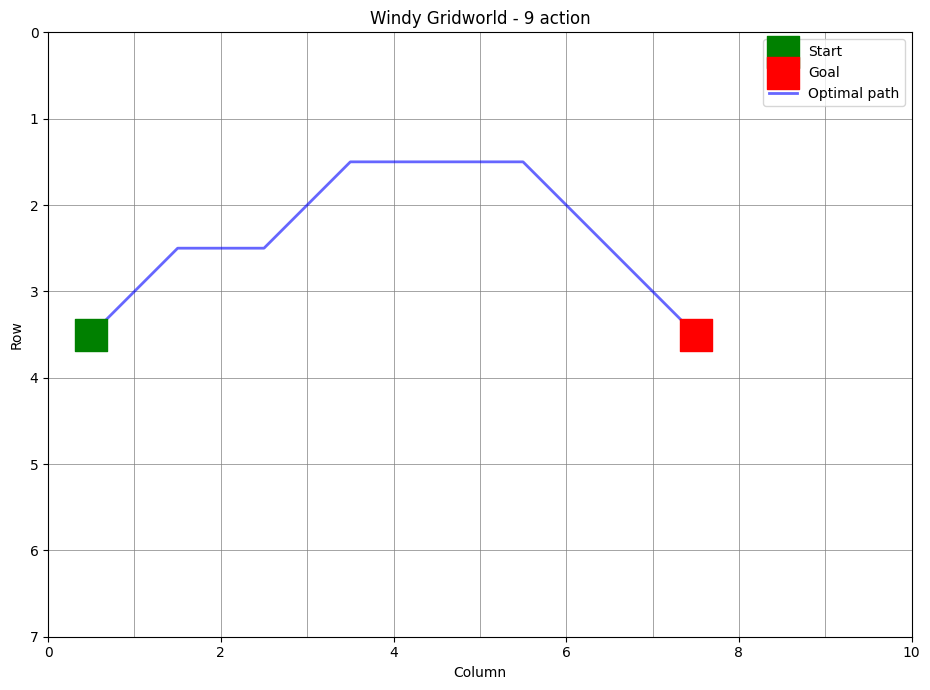

In [398]:
env = WindyGridworld(9)

Q, episode_lengths = sarsa(env, n_episodes=500, alpha=0.5, epsilon=0.1)

results[9] = (Q, episode_lengths)

visualize_grid_and_path(env, Q)

In [399]:
def visualize_results(results_dict):
    plt.figure(figsize=(12, 6))

    for action, (Q, episode_lengths) in results_dict.items():
        time_steps = np.cumsum(episode_lengths)
        episodes = np.arange(1, len(episode_lengths) + 1)

        plt.plot(time_steps, episodes, label=str(action) + " actions", linewidth=2)

    plt.xlabel("Time steps", fontsize=12)
    plt.ylabel("Episodes", fontsize=12)

    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.show()

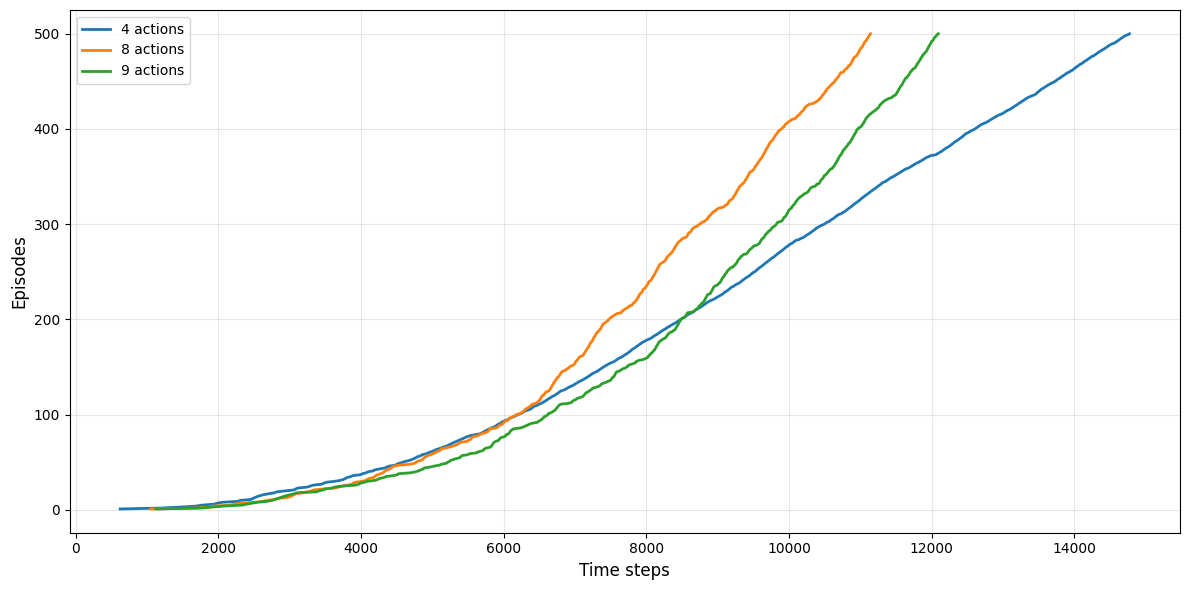

In [400]:
visualize_results(results)

### Code for Exercise 6.10


In [406]:
class StochasticWindyGridworld:
    def __init__(self, n_actions=8):
        self.height = 7
        self.width = 10

        self.start = (3, 0)
        self.goal = (3, 7)

        # Wind strength (mean values)
        self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

        self.actions = [
            (-1, 0),  # up
            (1, 0),  # down
            (0, 1),  # right
            (0, -1),  # left
            (-1, 1),  # up-right
            (-1, -1),  # up-left
            (1, 1),  # down-right
            (1, -1),  # down-left
        ]

        if n_actions == 9:
            self.actions += [(0, 0)]  # no-op

        self.n_actions = n_actions

    def step(self, state, action_idx):
        row, col = state
        action = self.actions[action_idx]

        # Apply action
        new_row = row + action[0]
        new_col = col + action[1]

        wind_strength = self.wind[col]
        wind_variation = np.random.choice([-1, 0, 1])
        actual_wind = wind_strength + wind_variation

        actual_wind = max(0, actual_wind)

        new_row -= actual_wind

        # Bound within grid
        new_row = max(0, min(self.height - 1, new_row))
        new_col = max(0, min(self.width - 1, new_col))

        next_state = (new_row, new_col)
        reward = -1

        return next_state, reward

    def is_terminal(self, state):
        return state == self.goal

    def reset(self):
        return self.start

In [407]:
results = {}

Length of Optimal Path: 21


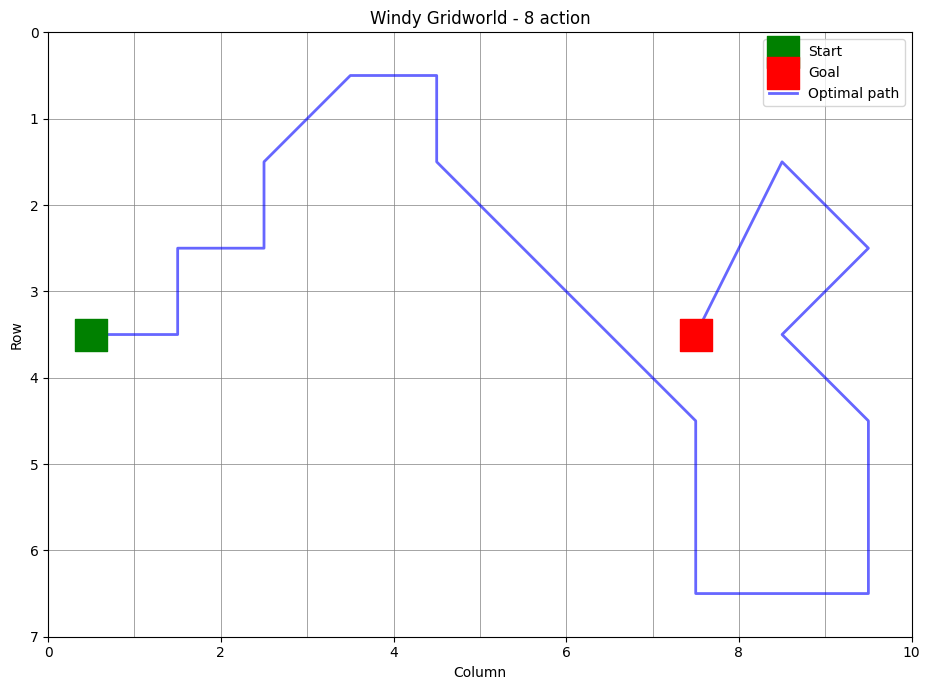

In [413]:
env = StochasticWindyGridworld(8)

Q, episode_lengths = sarsa(env, n_episodes=500, alpha=0.5, epsilon=0.1)

results[8] = (Q, episode_lengths)

visualize_grid_and_path(env, Q)

Length of Optimal Path: 18


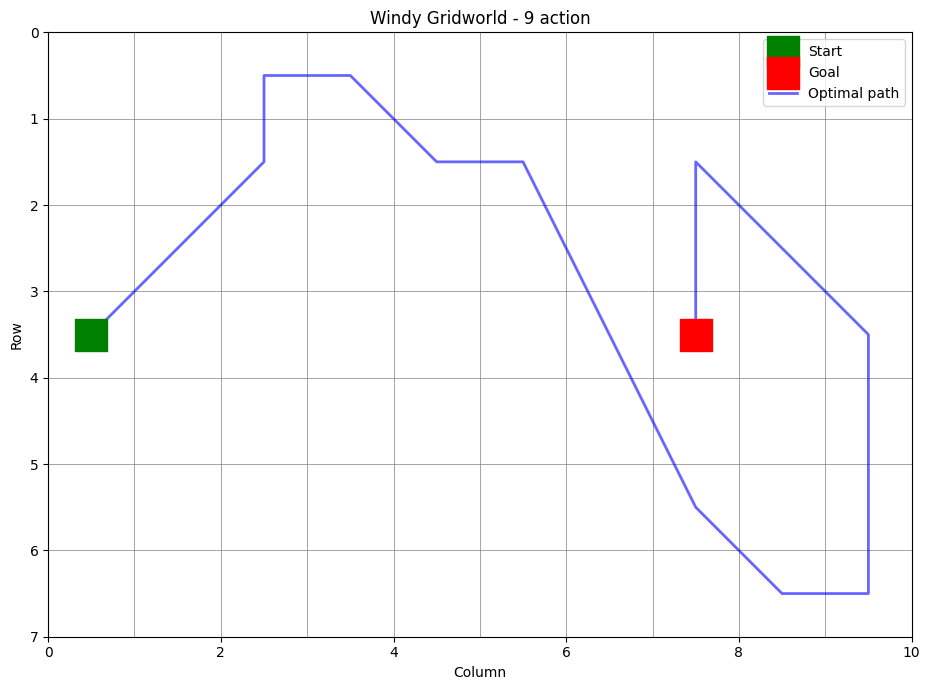

In [449]:
env = StochasticWindyGridworld(9)

Q, episode_lengths = sarsa(env, n_episodes=500, alpha=0.5, epsilon=0.1)

results[9] = (Q, episode_lengths)

visualize_grid_and_path(env, Q)

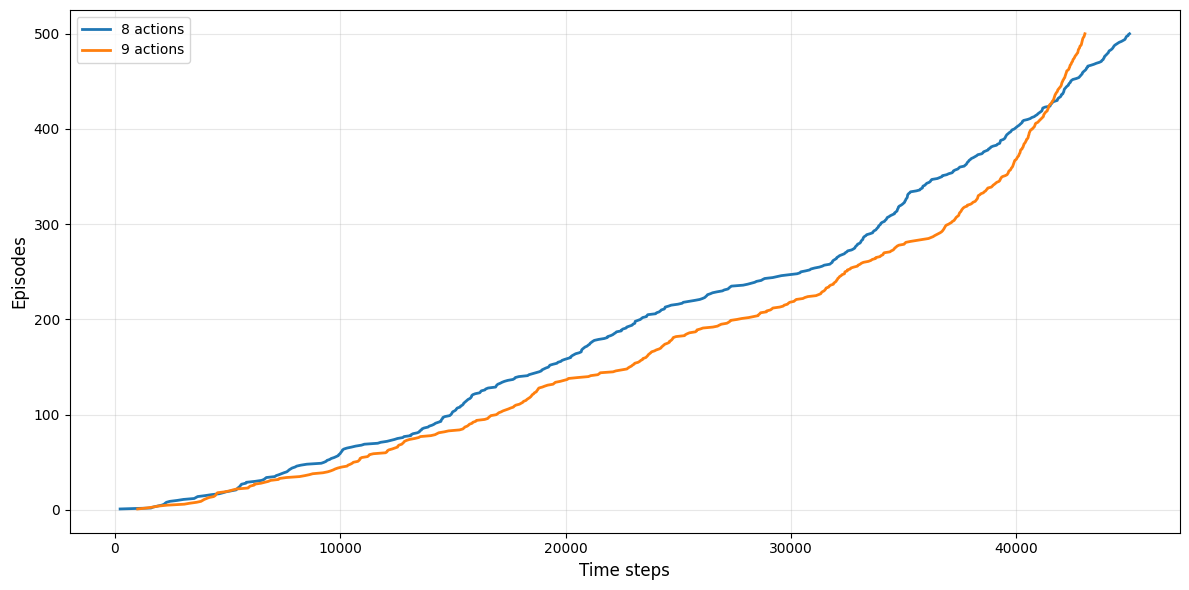

In [450]:
visualize_results(results)